In [1]:
!(lscpu 2>/dev/null || sysctl -n machdep.cpu.brand_string) && \
(free -h 2>/dev/null || vm_stat | head -5) 

Apple M4 Pro
Mach Virtual Memory Statistics: (page size of 16384 bytes)
Pages free:                               22005.
Pages active:                           1200249.
Pages inactive:                         1179810.
Pages speculative:                        20027.


In [2]:
import os
import scanpy as sc
import CoCoSTpy as cocost

### Data Source

The example datasets are obtained from the **10x Genomics Visium Data Portal**.

- **`Visium_FFPE_Human_Normal_Prostate`**: [link](https://www.10xgenomics.com/cn/datasets/normal-human-prostate-ffpe-1-standard-1-3-0)  
- **`Visium_FFPE_Human_Prostate_Cancer`**: [link](https://www.10xgenomics.com/cn/datasets/human-prostate-cancer-adenocarcinoma-with-invasive-carcinoma-ffpe-1-standard-1-3-0)

In [3]:
data_path = "/Users/poncey/Downloads/10xVisium-ProstateCancer"
data_names = ['HPC_AcinarCa', 'HPC_AdjNormal_IF', 'HPC_AdenoInvCa', 'HP_Normal']
adata1 = sc.read_h5ad(os.path.join(data_path, "hp_normal.h5ad"))
adata2 = sc.read_h5ad(os.path.join(data_path, "hpc_adenoinvca.h5ad"))

sc.pp.filter_cells(adata1, min_counts=10)
sc.pp.filter_genes(adata1, min_counts=20)
sc.pp.filter_cells(adata2, min_counts=10)
sc.pp.filter_genes(adata2, min_counts=20)

adata1.obs["Usage"] = ["Background"] * adata1.shape[0]
adata2.obs["Usage"] = ["Target"] * adata2.shape[0]


def find_comparable_hvg(ad1, ad2, batch_key, n_hvg: int = 2000,):
    cm_var_n = ad1.var_names.intersection(ad2.var_names)
    ad_concat = sc.concat([ad1[...,cm_var_n], ad2[...,cm_var_n]])
    sc.pp.highly_variable_genes(ad_concat, n_top_genes=n_hvg, batch_key=batch_key, flavor="seurat_v3")
    return ad_concat.var.sort_values(by="highly_variable_rank").index[:2000]
cm_hvg = find_comparable_hvg(adata1, adata2, batch_key="Usage")

/opt/miniconda3/envs/qiuying/lib/python3.12/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata1.layers["count"] = adata1.X.copy()
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
adata2.layers["count"] = adata2.X.copy()
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)

In [5]:
sf1 = adata1.uns["spatial"]['Visium_FFPE_Human_Normal_Prostate']['scalefactors']['fiducial_diameter_fullres']
sf2 = adata2.uns["spatial"]['Visium_FFPE_Human_Prostate_Cancer']['scalefactors']['fiducial_diameter_fullres']
cocost.spatial_affinity(adata1, scale_factor=sf1)
cocost.spatial_affinity(adata2, scale_factor=sf2)

In [6]:
cocost.cocost(adata1, adata2, use_genes=cm_hvg)

In [7]:
sc.pp.neighbors(adata2, use_rep="X_CoCoST")
sc.tl.umap(adata2)
sc.tl.leiden(adata2, resolution=.5)

/var/folders/m7/t1p8275d4db43tz2vrxwjf380000gn/T/ipykernel_44931/3284443432.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata2, resolution=.5)


/var/folders/m7/t1p8275d4db43tz2vrxwjf380000gn/T/ipykernel_44931/2918784708.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata2, color="leiden")


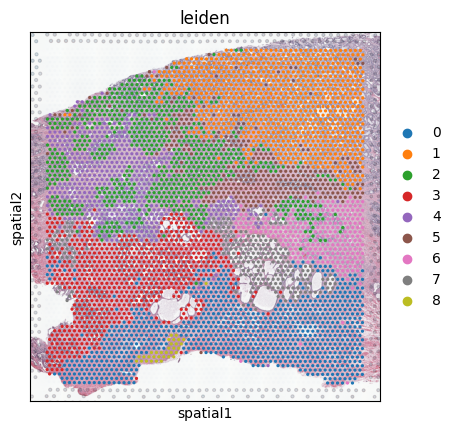

In [8]:
sc.pl.spatial(adata2, color="leiden")